In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)
import seaborn as sns
sns.set_palette("pastel") 

from IPython.display import display, Math, clear_output
from sympy import Matrix
from sympy import latex, symbols

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.tsatools import vech

from scipy.optimize import least_squares
from scipy.optimize import fsolve
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import f

from pathlib import Path
import pandas as pd
import numpy as np
import random
import sys
import os

import warnings
warnings.filterwarnings("ignore", message="Setting `xtol` below the machine epsilon")
warnings.filterwarnings("ignore", message="Setting `gtol` below the machine epsilon")
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 2

current_dir = Path.cwd()
sys.path.append(f"{current_dir}")

# Save output:
Python_path = None
LaTeX_path = None # LaTeX editor Texifier for macOS (https://www.texifier.com) highly recommended


pd.options.display.float_format = '{:.4f}'.format  # Ændrer til 4 decimale4

color_navy = '#{:02x}{:02x}{:02x}'.format(85, 108, 131)
colors_navy = ["#a5c6e2", "#80afd6", "#5b97ca", "#3b7fb9", "#2f6694", "#234c6f", "#17334a", "#0b1925"]
colors_pastel = sns.color_palette("pastel", 10)
colors_pastel

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [1]:
# Data:
dataM = pd.read_excel(f'{current_dir}/Data & Estimates/2024 Homework Assignment | Monthly.xls')
dataQ = pd.read_excel(f'{current_dir}/Data & Estimates/2024 Homework Assignment | Quarterly.xls')

# Homework Assignment 1
VAR Model specication and estimation


The assignment must be prepared either individually or in groups of three to four students but should be handed in individually in Absalon in pdf format. The title page must include a list of all members of the group. Everyone is responsible for writing their own code. All necessary programs must be submitted including a description of the analysis undertaken and a short discussion of the results. Note, only new functions coded in either Python or Matlab should be submitted. Any function distributed during lectures or exercises should not be submitted. Note that you are not allowed to use built-in functions available in Python/MATLAB unless otherwise stated.


The empirical application focuses on the eects of monetary policy on exchange rates analyzed in Bjørnland (2009) but we have updated the data set. Both this paper and the data can be downloaded from the homepage.

Download the datales Canada Monthly Data.xls and the Canada Quarterly Data.xls.

##  $\text{Q1\quad Descriptive Statistics}$
Transform the quarterly data as suggested in Bjørnland (2009). Plot the transformed time series. Are these time series stationary? Is there a linear trend? Provide descriptive statistics such as mean, median, min, max, number of observations and standard deviations in a table. Note, you need to transform federal funds rate, the exchange rate and ination to quarterly frequency.

In [2]:
datesQ = dataQ.iloc[:, 0]
GDP = np.log(dataQ.iloc[:, 1])
IntRate = dataQ.iloc[:, 3]

resultTable1 = pd.DataFrame({'Dates': datesQ, 'GDP': GDP, 'IntRate': IntRate})

# Load and process monthly data
datesM = dataM.iloc[:, 0]
ExchangeRate = dataM.iloc[:, 1]
FedFunds = dataM.iloc[:, 2]
CPIMonthly = dataM.iloc[:, 4]
IntRateMonthly = dataM.iloc[:, 5]

# Aggregate monthly data to quarterly means
TimeTable1 = pd.DataFrame({'Dates': datesM, 'ExchangeRate': ExchangeRate, 'FedFunds': FedFunds, 'IntRateMonthly': IntRateMonthly})
TimeTable1.set_index('Dates', inplace=True)
TimeTable1 = TimeTable1.resample('QS').mean()

ExchangeRateQ = TimeTable1.iloc[:, 0]
FedFundsQ = TimeTable1.iloc[:, 1]
IntRateQ = TimeTable1.iloc[:, 2]

# Calculate exchange rate changes
ExchangeRateChange = 100 * (np.log(ExchangeRateQ) - np.log(ExchangeRateQ.shift(1)))

TimeTable1 = pd.concat([ExchangeRateChange, FedFundsQ, IntRateQ], axis=1)

Infl = 100 * (np.log(CPIMonthly) - np.log(CPIMonthly.shift(12)))

TimeTable2 = pd.DataFrame({'Dates': datesM, 'Infl': Infl})
TimeTable2.set_index('Dates', inplace=True)
TimeTable2 = TimeTable2.resample('QS').mean()

resultTable2 = pd.merge(TimeTable1, TimeTable2, on='Dates', how='left')

resultTable2

result = pd.merge(resultTable1, resultTable2, on='Dates', how='left')
result = result[['Dates', 'FedFunds', 'GDP', 'Infl', 'IntRate', 'ExchangeRate']]
result = result.dropna()
result.reset_index(inplace=True,drop=True)
date_column_name = [col for col in result.columns if col == 'Dates']
date_column_name = date_column_name[0]
display(result)

,Dates,FedFunds,GDP,Infl,IntRate,ExchangeRate
0,1972-01-01,3.5400,25.7468,4.5220,4.6053,0.0399
1,1972-04-01,4.3000,25.7747,3.7049,5.7618,-1.5068
2,1972-07-01,4.7400,25.7774,4.5663,4.9470,-0.4972
3,1972-10-01,5.1433,25.8009,4.5547,5.0780,0.5916
4,1973-01-01,6.5367,25.8266,4.7622,5.0520,0.8291
...,...,...,...,...,...,...
189,2019-04-01,2.3967,26.9832,2.1891,1.8567,0.6174
190,2019-07-01,2.1900,26.9860,2.4318,1.8367,-1.2741
191,2019-10-01,1.6433,26.9874,2.7622,1.8667,-0.0606
192,2020-01-01,1.2600,26.9661,2.1200,1.6600,1.8517


In [3]:
# Very important:
list_of_info = ["Dates: 1965-2015 (monthly)","Foreign Interest","Gross Domestic Product", "Inflation","Interest Rate","Exchange Rate"]
list_of_info_latex = [r"$i^\ast_t$", r"$y_t$", r"$\pi_t$", r"$i_t$", r"$\Delta e_t$"]

K = len(result.drop(columns=["Dates"]).columns)

# Package/module:
from Structural_Vector_Autoregressive_Analysis import BaseClass

# Initialiser BaseClass med ønskede parametre
Base_initialize = BaseClass(LaTeX_path = None,                          # Can be None or LaTeX_path if LaTeX_path it will save Tables/Plots to the LaTeX_path
                            Python_path = Python_path,                  # Path to Python folder
                            list_of_info_latex = list_of_info_latex,    # List of variable
                            list_of_info = list_of_info,                # List of names for each variable 
                            # Path to JCV.npy, PSSCV.npy and SigLevels.xlsx
                            path = f"{current_dir}/Data & Estimates/")    

from Structural_Vector_Autoregressive_Analysis import Initial_Tools as SVAR_IT
SVAR_IT = SVAR_IT(Base_initialize, date_column="Dates")

In [4]:
from Structural_Vector_Autoregressive_Analysis import Initial_Tools as SVAR_IT
SVAR_IT = SVAR_IT(Base_initialize, date_column=date_column_name)

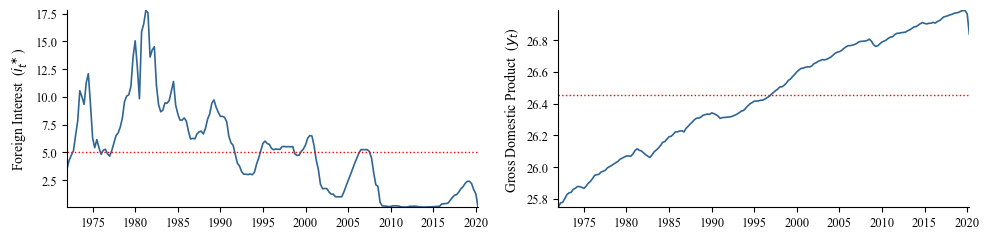

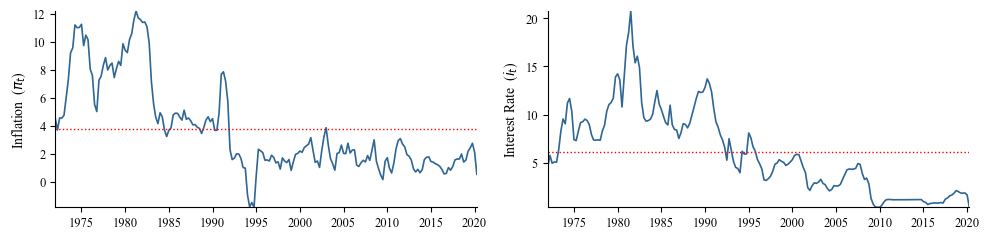

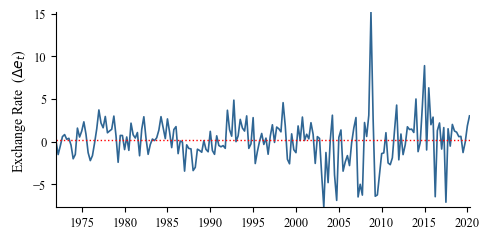

All variables have the same sample size: 194


,Mean,Median,Min,Max,Std. Dev.
Foreign Interest,5.0785,5.1617,0.0600,17.7800,3.9688
Gross Domestic Product,26.4515,26.4255,25.7468,26.9874,0.3542
Inflation,3.7871,2.3489,-1.7968,12.1785,3.2390
Interest Rate,6.0633,5.1077,0.3767,20.7375,4.3397
Exchange Rate,0.1668,0.4156,-7.6812,15.1408,2.6500


In [5]:
SVAR_IT.Data_plot(result,Save=False)
SVAR_IT.Descriptive_Statistics(result, display_data=True)
y_clean_data = SVAR_IT.clean_data(result,display_data=False)

##  $\text{Q2\quad Information Criteria}$

Code the multivariate Akaike, Schwarz and Hannan-Quinn information criteria either in Python or in Matlab.

In [6]:
from Structural_Vector_Autoregressive_Analysis import Lag_Order_Determination as SVAR_LOD
SVAR_LOD = SVAR_LOD(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Diagnostic_Testing as SVAR_DT
SVAR_DT = SVAR_DT(Base_initialize, y_dataframe=y_clean_data)
 
from Structural_Vector_Autoregressive_Analysis import Univariate_Diagnostic_Testing as SVAR_UDT
SVAR_UDT = SVAR_UDT(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Testing_Cointegration as SVAR_TC
SVAR_TC = SVAR_TC(Base_initialize, y_dataframe=y_clean_data)

In [7]:
_ = SVAR_LOD.Information_Criteria(maximum_lag_length=12, Trend=False, Show=True)

Lag,SIC,HQ,AIC
0,3.382377,3.330038,3.294355
1,-8.186434,-8.500469,-8.714567
2,-8.183933,-8.759665,-9.152177
3,-7.584138,-8.421566,-8.992493
4,-7.043167,-8.142291,-8.891632
5,-6.691843,-8.052663,-8.980419
6,-6.332775,-7.955292,-9.061462
7,-5.812190,-7.696404,-8.980988
8,-5.249111,-7.395020,-8.858019
9,-4.669080,-7.076686,-8.718099


The three common information criteria known as The Akaike Information Criterion (AIC), Hannan-Quin Criterion (HQC) and the Schwarz Information Criterion (SIC). 

The AIC is given as:

\begin{equation*}
    \text{AIC}(m) = \log\left(\det\left(\widetilde{\Sigma}_{u}(m)\right)\right) + \frac{2}{T}\left(mK^{2} + K\right)
\end{equation*}
The HQC is given as:


\begin{equation*}
    \text{HQC}(m)=\log\left(\det\left(\widetilde{\Sigma}_{u}(m)\right)\right)+\frac{2\log(\log(T))}{T}\left(mK^{2}+K\right)
\end{equation*}

The SIC is given as:

\begin{equation*}
    \text{SIC}(m)=\log\left(\det\left(\widetilde{\Sigma}_{u}(m)\right)\right)+\frac{\log(T)}{T}\left(mK^{2}+K\right)
\end{equation*}


where $\widetilde{\Sigma}_{u}(m)=T^{-1}\sum_{t=1}^{T}\hat{u}_{t}\hat{u}_{t}^{\prime}$ is the covariance matrix estimator for the least square residual, $\hat{u}_{t}$, at a given lag order, $m$. $K$ is the number of equations in the model and $T$ is the number of observations used. 


### $\text{Top-Down Sequential Test}$

Instead of calculating the information criteria, one can perform a top-down sequential test. Letting $A_t$ denote the coefficient at a given lag length, Kilian and Lütkepohl (2017), p. 51, notes that:

One possible sequential procedure involves testing the sequence of null hypotheses:
$$
\begin{alignat*}{2}
&&\mathbb{H}_{0}: ~A_{p_{\text{max}}} = 0\quad\textit{versus}&\quad \mathbb{H}_{1}: A_{p_{\text{max}}} \neq 0\\
&&\mathbb{H}_{0}: ~A_{p_{\text{max}}-1} = 0\quad\textit{versus}&\quad \mathbb{H}_{1}: A_{p_{\text{max}}-1} \neq 0\\
&&~\vdots&\\
&&\mathbb{H}_{0}: ~A_{1} = 0\quad\textit{versus}&\quad \mathbb{H}_{1}: A_{1} \neq 0
\end{alignat*}
$$
The procedure continues, as long as the null hypothesis is not rejected. If there is a rejection, the testing procedure terminates, and we conclude that we require as many lags as maintained under the last alternative hypothesis. If none of the null hypotheses can be rejected, we conclude that $p = 0$. Such procedures are known as top-down or general-to-specific procedures because they start with the largest model and sequentially reduce the lag order of the model. In implementing this sequential test, the usual Wald or LR tests for parameter restrictions can be employed. For example, the LR statistic for testing a VAR($m$) against a VAR($m + 1$) has the form

\begin{equation*}
LR(m) = T \left[ \log(\det(\widetilde{\Sigma}_{u}(m))) - \log(\det(\widetilde{\Sigma}_{u}(m+1))) \right]
\end{equation*}

where

\begin{equation*}
\widetilde{\Sigma}_{u}(m) = T^{-1} \sum_{t=1}^{T} \hat{u}_{t} \hat{u}_{t}'
\end{equation*}

is the ML estimator of the residual covariance matrix for a VAR($m$) model. 
One also could alternatively use the LS residuals $\hat{u}_{t}$. 
If $H_{0}: A_{m+1} = 0$ is tested against $H_{1}: A_{m+1} \neq 0$, 
the $LR(m)$ statistic has an asymptotic $\chi^{2}(K^{2})$ distribution under $H_{0}$.

In [8]:
_ = SVAR_LOD.Top_Down_Sequence(maximum_lag_length=12, Trend=False, Show=True)
# # Michael Bergman's computed log-likelihood differs from this one.
# # LR test and p-value is the same.

Lag,Log. Likelihood,LR test,p-value
0,589.572610,,
1,-1646.051153,2235.623764,0.000000
2,-1775.696251,129.645098,0.000000
3,-1796.633661,20.937410,0.696094
4,-1828.277082,31.643420,0.168590
5,-1894.436209,66.159128,0.000014
6,-1959.186156,64.749947,0.000022
7,-1994.539840,35.353684,0.081995
8,-2022.159488,27.619649,0.325657
9,-2046.694106,24.534617,0.488682


##  $\text{Q3\quad Lag Length}$

Determine the lag length in the VAR model using information criteria and compare to the lag length suggested by the top-down procedure. You can use the code submitted during the lectures to nd the lag length using the top-down sequence.

In [9]:
SVAR_LOD.Combined_Lag_Selection(maximum_lag_length=12, Trend = False, LaTeX=False)

Lag,SIC,HQ,AIC,LR Test
0,3.382,3.330,3.294,
1,-8.186,-8.500,-8.715,2235.624***
2,-8.184,-8.760,-9.152,129.645***
3,-7.584,-8.422,-8.992,20.937
4,-7.043,-8.142,-8.892,31.643
5,-6.692,-8.053,-8.980,66.159***
6,-6.333,-7.955,-9.061,64.75***
7,-5.812,-7.696,-8.981,35.354*
8,-5.249,-7.395,-8.858,27.62
9,-4.669,-7.077,-8.718,24.535


##  $\text{Q4\quad Autocorrelation - LM tests}$
Code functions computing the LM test either in Python or in Matlab for autocorrelation proposed by Breusch and Godfrey and the test suggested by Edgerton-Shukur. These tests are described in KL section 2.6.2. Useful references also include Lütkepohl (2004), Brüggeman, Lütkepohl and Saikkonen (2006) and Edgerton and Shukur (1999) for alternative descriptions of the test statistics.

### $\text{Stable/stability condition}$


The matrix $\boldsymbol{A}$ is referred to as the companion matrix of the VAR($p$) process. Using the stability condition (2.2.5), $Y_t$ is stable if
$$\det(I_{Kp}-\boldsymbol{A}z)\ne 0\quad\forall z\in \mathbb{C},\qquad |z|\leq 1$$

which, of course, is equivalent to condition (2.2.5). It is easy to see that this condition is equivalent to all eigenvalues of $\boldsymbol{A}$ having modulus less than one, which provides a convenient tool for assessing the stability of a VAR model and for computing the autoregressive roots. By construction, the eigenvalues of $\boldsymbol{A}$ are the reciprocals of the roots of the VAR lag polynomial (2.2.5).

In [10]:
SVAR_DT.Eigenvalue_Long_Table(maximum_lag_length=3,LaTeX=False)

Lags,Eigenvalues,i^\ast_t,y_t,\pi_t,i_t,\Delta e_t,Trend,Constant
Lag 1,λ_{p=1},1.000216,0.955431,0.902420,0.902420,0.256996,False,False
,λ_{p=1},1.000373,0.907663,0.901124,0.901124,0.257093,True,False
,λ_{p=1},0.995078,0.904729,0.899383,0.899383,0.256029,False,True
,λ_{p=1},1.010147,0.913969,0.913969,0.901187,0.231223,True,True
Lag 2,λ_{p=1},0.998986,0.998986,0.890590,0.890590,0.650643,False,False
,λ_{p=2},0.432357,0.287805,0.287805,0.273588,0.273588,False,False
,λ_{p=1},1.000371,0.899732,0.862375,0.862375,0.601837,True,False
,λ_{p=2},0.451436,0.291649,0.291649,0.280892,0.280892,True,False
,λ_{p=1},0.994394,0.907260,0.851035,0.851035,0.650461,False,True
,λ_{p=2},0.443949,0.288053,0.288053,0.286692,0.286692,False,True


In [11]:
SVAR_DT.Eigenvalue_Short_Table(maximum_lag_length=3, LaTeX=False)

Lag,"No Constant, No Trend",Constant Only,Trend Only,Constant and Trend
1,1.000216,0.995078,1.000373,1.010147
2,0.998986,0.994394,1.000371,1.016205
3,1.007355,0.994598,1.000376,1.011827


### $\text{Autocorrelation-LM tests}$

Consider the following AR($p$)-process:
\begin{equation*}
y_{t} = \nu + \rho_{1}y_{t-1} + \rho_{2}y_{t-2} + \cdots + \rho_{p}y_{t-p} + u_{t}
\end{equation*}
where $ \rho_{1}, \rho_{2}, \ldots, \rho_{p} $ are the autoregressive coefficients of the model, $ u_{t} $ is an error term and $ \nu $ a constant. Then, a test for autocorrelation in the innovations, $ u_{t} $, proposed by Breusch (1978) and Godfrey (1978) can be seen using the model:
\begin{equation*}
u_{t} = D_{1}u_{t-1} + D_{2}u_{t-2} + \cdots + D_{h}u_{t-h} + e_{t}
\end{equation*}
$\qquad$ where $ e_{t} $ is a white noise error term. The test for no autocorrelation in $ u_{t} $ is then:
\begin{equation*}
\begin{aligned}
H_{0} &: D_{1} = \cdots = D_{h} = 0 \quad \text{versus} \\
H_{1} &: D_{i} \neq 0 \text{ for at least one } i \in \{1, \dots, h\}
\end{aligned}
\end{equation*}

In theory, $ u_{t} $ should be indendent and identically distributed (iid.). However, the estimated residuals, $ \hat{u}_{t} $, that we need to use are not necessarily iid. The original variable $ y_{t-1} $ might be correlated with $ \hat{u}_{t-1} $, $ y_{t-2} $ with $ \hat{u}_{t-2} $ and so on. Therefore, we need to expand the model for $ \hat{u}_{t} $ to also include the original variables:
\begin{equation*}
\hat{u}_{t} = \nu + \rho_{1}y_{t-1} + \rho_{2}y_{t-2} + \cdots + \rho_{p}y_{t-p} + D_{1}\hat{u}_{t-1} + D_{2}\hat{u}_{t-2} + \cdots + D_{h}\hat{u}_{t-h} + e_{t}
\end{equation*}
$\qquad$ where $ e_{t} $ is an auxiliary error term. At last, the Lagrange multiplier test statistic (also known as the Breusch-Godfrey test statistic) can be computed as:
\begin{equation*}
Q_{LM} = T \left(K - \text{tr}(\widetilde{\Sigma}_{u}^{-1} \widetilde{\Sigma}_{e})\right)
\end{equation*}
$\qquad$ where $ \widetilde{\Sigma}_{u} = T^{-1} \sum_{t=1}^{T} \hat{u}_{t} \hat{u}_{t}^{\prime} $, $ \widetilde{\Sigma}_{e} = T^{-1} \sum_{t=1}^{T} \hat{e}_{t} \hat{e}_{t}^{\prime} $ and $ K $ is the number of equations.
$$~$$
****
$$~$$
Edgerton and Shukur (1999) proposes a small sample version of the LM test given as:

\begin{equation*}
\text{FLMh}=\left(\left(\det(\Sigma_{u})\det(\Sigma_{e})^{-1}\right)^{\frac{1}{s}}-1\right)\cdot\left(\frac{Ns-q}{Km}\right)
\end{equation*}
$\qquad$ where:
\begin{equation*}
\begin{aligned}
m & =Kh\\
q & =\frac{1}{2}Km-1\\
s & =\left(\frac{K^{2}\cdot m^{2}-4}{K^{2}+m^{2}-5}\right)^{\frac{1}{2}}\\
N & =T-Kp-m-\frac{1}{2}(K-m+1)
\end{aligned}
\end{equation*}

In [12]:
Constant = True
Trend = False
p = 2 # VAR Lags

_, _, _, residuals, _, SIGMA = SVAR_DT.VAR_estimation_with_exogenous(lags=p,Constant=Constant,Trend=Trend)
lags_q = 2 # ARCH Lags
lag_h = 6  # Autocorrelation (LM and Portmanteau)

In [13]:
SVAR_DT.Autocorrelation_LM_Table(lags=p, Constant=Constant, Trend=Trend, Exogenous=None, lags_h=lag_h, LaTeX=False)

Lags (h),Breusch Godfrey,Edgerton Shukur
1,26.771,1.02
2,60.858,1.172
3,93.514*,1.204
4,174.573***,1.866***
5,152.098**,1.313**
6,-1100.517,-0.778


## $\text{Q5\quad Autocorrelation, Normality and Multivariate ARCH}$

Test for multivariate autocorrelation, normality and multivariate ARCH in the residuals from the selected VAR model using your coded functions and the functions provided during the lectures. To check the results, use the built-in Python or Matlab functions for univariate tests for autocorrelation and heteroscedasticity. Summarize the results in a table and comment.

### $\text{Portmanteau Test for Residual Autocorrelation}$

The Portmanteau test for autocorrelation in the innovations evaluates the null hypothesis 
$$\mathbb{H}_0:\quad\mathbb{E}(u_tu'_{t-i})=0, \qquad i=1,2,...$$
The alternative hypothesis is that at least one autocovariance is nonzero. 

The test statistic is
$$Q_h=T\sum^h_{j=1}\text{tr}\Big(\hat{C}_j'\hat{C}_0^{-1}\hat{C}_j\hat{C}^{-1}_0\Big)\tag{2.6.1}$$

where $\hat{C}_j=T^{−1}\sum^T_{t=j+1}\hat{u}_t\hat{u}_{t-j}'$ and the $\hat{u}_t$ are the ${\small\text{LS}}$ residuals. In other words, the test statistic is based on the estimated residual autocovariances. If the VAR($p$) process is stationary, no parameter restrictions are imposed and the errors are serially independent, the distribution of $Q_h$ under $\mathbb{H}_0$ is approximately $\chi^2(K^2(h-p))$ when both $T$ and h are large. The approximate $\chi^2$ distribution is obtained, specifically, as $h/T\to 0$ for $T\to\infty$. The degrees of freedom have to be adjusted, if there are parameter restrictions. In that case, they are obtained as the diﬀerence between the number
of (non-instantaneous) autocovariances included in the statistic $(K^2h)$ and the number of estimated VAR parameters (e.g., $\text{Ahn (1988)}$, $\text{Hosking (1980, 1981a, 1981b)}$, $\text{Li and McLeod (1981)}$ or 
$\text{Lütkepohl(2005)}$, Section (5.2.9))


Even when the necessary conditions for deriving the asymptotic distribution hold, the approximate $\chi^2$ distribution may be far from the actual distribution in small samples. To improve the match between actual and approximating distribution, the following modified statistic was proposed by Hosking (1980):

$$Q_h=T^2\sum^h_{j=1}\frac{1}{T-j}\cdot\text{tr}\Big(\hat{C}_j'\hat{C}_0^{-1}\hat{C}_j\hat{C}^{-1}_0\Big)$$


The number $h$ of autocovariance terms in the test statistic should be considerably larger than $p$ for a good approximation to the null distribution. Choosing $h$ is too large, however, may undermine the power of the test. In practice, usually a number of diﬀerent values of $h$ is considered. Generally, the Portmanteau test should be applied to test a large number of autocovariances. It is not suitable for a more targeted test of low-order autocorrelation. For the latter purpose the ${\small \text{LM}}$ test considered in the next section is preferred.

In [14]:
SVAR_DT.Multivariate_Portmanteau(residuals=residuals, lag_h=lag_h, lags=p)

,,Portmanteau,Modified Portmanteau
0,Test Statistic,134.5554,137.3961
1,p-value,0.0121,0.0078
2,Degrees of Freedom,100.0000,100.0000


### $\text{Normality}$

A test for skewness is given by:

\begin{equation*}
\lambda_{3} = \frac{\hat{b}_{3}^{\prime} \hat{b}_{3}}{3} \overset{d}{\rightarrow} \chi^{2}(K)
\end{equation*}

where $\hat{b}_{j}^{\prime} = (\hat{b}_{1j}, \dots, \hat{b}_{Kj})^{\prime}$ and $\hat{b}_{kj} = \frac{1}{T} \sum_{t=1}^{T} (\hat{u}_{kt}^{s})^{j}$. $K$ is the number of variables, while the residuals are standardized such that $\hat{u}_{t}^{s} = P^{-1} \hat{u}_{t}$ and $\tilde{\Sigma}_{u} = P P^{\prime}$. Doornik and Hansen (1994) uses the square root matrix of $\tilde{\Sigma}_{u}$, whereas Lütkepohl (2005, Chapter 4) uses the Cholesky decomposition.

A test for excess kurtosis is given by:

\begin{equation*}
\lambda_{4} = \frac{(\hat{b}_{4} - 3_{K})^{\prime} (\hat{b}_{4} - 3_{K})}{24} \overset{d}{\rightarrow} \chi^{2}(K)
\end{equation*}

where $3_{K} = (3, \dots, 3)^{\prime}$ is a $K \times 1$ vector.

At last, a test for non-normality is given by:

\begin{equation*}
\lambda = \lambda_{3} + \lambda_{4} \sim \chi^{2}(2K)
\end{equation*}


In [15]:
SVAR_DT.Multivariate_Normality(residuals=residuals)

,Test,Doornik_Hansen,Lutkepohl
0,Joint test statistic:,33231.0363,39564.5307
1,P-value,0.0000,0.0000
2,Degrees of freedom,10.0000,10.0000
3,Skewness only,1278.6664,1497.2298
4,P-value,0.0000,0.0000
5,Kurtosis only,31952.3698,38067.3008
6,P-value,0.0000,0.0000


### $\text{ARCH}$

Given the auxiliary model of horizontally stacked residuals:

\begin{equation*}
\text{vech}(\hat{u}_t \hat{u}_t') = \delta_0 + D_1 \text{vech}(\hat{u}_{t-1} \hat{u}_{t-1}') + \dots + D_q \text{vech}(\hat{u}_{t-q} \hat{u}_{t-q}') + e_t.
\end{equation*}

We have that there are no ARCH effect given that the following null hypothesis is true:

\begin{equation*}
H_0 : D_1 = \cdots = D_q = 0 \quad \text{versus} \quad H_1 : D_i \neq 0 \, \text{for at least one} \, i \in \{1, \dots, q\}.
\end{equation*}

The test for residuals ARCH effects can be calculated using the LM-test:

\begin{equation*}
LM_{\text{ARCH}}(q) = \frac{1}{2} T K (K + 1) \left( 1 - \frac{2}{K (K + 1)} \text{tr}(\hat{\Omega} \hat{\Omega}_{0}^{-1}) \right)
\end{equation*}

where $\hat{\Omega}$ is the residual covariance matrix of the auxiliary regression, $\hat{\Omega}_{0}$ is the covariance matrix under the null hypothesis of no ARCH, and $T$ is the sample size. The null hypothesis is that there is no ARCH effect up to lag $q$.

In [16]:
SVAR_DT.Multivariate_ARCH(residuals=residuals, lags_q=lags_q)

,Test,Doornik_Hendry
0,Test statistic,496.9863
1,P-value,0.0622
2,Degrees of freedom,450.0000


In [17]:
SVAR_DT.Diagnostic_Table(residuals = residuals, 
                         Constant = Constant, 
                         lags_q = lags_q, 
                         lags_h = lag_h,
                         Trend = Trend, 
                         lags = p,
                         LaTeX = False)

,Doornik Hendry,Doornik Hansen,Lutkepohl,Portmanteau,Portmanteau Modified
Joint test,496.986*,33231.036***,39564.531***,134.555**,137.396***
Skewness test,,1278.666***,1497.23***,,
Kurtosis test,,31952.37***,38067.301***,,


#### $$\text{Univariate Tests for {\small ARCH}, Normality, and Autocorrelation}$$

In [18]:
print("\nUnivariate ARCH Test - Het_ARCH")
display(SVAR_UDT.Univariate_ARCH_Test(residuals=residuals,lags=p))
print("\nUnivariate Normality Test - Jarque_Bera")
display(SVAR_UDT.Univariate_Normality_Test(residuals=residuals))
print("\nUnivariate Autocorrelation Test - Ljung-Box")
display(SVAR_UDT.Univariate_Autocorrelation_Test(residuals=residuals, lag_h=lag_h))

SVAR_UDT.Combined_Univariate_LaTeX(residuals=residuals,lags=p,lag_h=lag_h, LaTeX=False)


Univariate ARCH Test - Het_ARCH


,Hypothesis,P-Value,Test Statistic,Critical Value
Foreign Interest,1.0000,0.0172,8.1234,5.9915
Gross Domestic Product,1.0000,0.0000,24.8465,5.9915
Inflation,0.0000,0.7938,0.4618,5.9915
Interest Rate,0.0000,0.0780,5.1027,5.9915
Exchange Rate,0.0000,0.0631,5.5264,5.9915



Univariate Normality Test - Jarque_Bera


,Hypothesis,P-Value,Test Statistic,Critical Value
Foreign Interest,1.0000,0.0000,2903.8812,5.9915
Gross Domestic Product,1.0000,0.0000,35207.2159,5.9915
Inflation,1.0000,0.0000,19.9820,5.9915
Interest Rate,1.0000,0.0000,269.4605,5.9915
Exchange Rate,1.0000,0.0000,277.4394,5.9915



Univariate Autocorrelation Test - Ljung-Box


,Foreign Interest,Gross Domestic Product,Inflation,Interest Rate,Exchange Rate
Lag 1,0.0595,0.2044,0.0063,0.8623,0.0014
Lag 2,6.2669**,0.6853,0.0063,2.7483,0.0017
Lag 3,9.3661**,1.2872,2.5511,3.5176,0.0486
Lag 4,10.5764**,1.5369,27.1886***,4.3825,0.1078
Lag 5,14.9998**,1.645,31.2058***,7.1136,1.4294
Lag 6,15.1886**,1.772,38.32***,8.4558,1.4603


## $\text{Q6\quad Test for cointegration}$

Test for cointegration using the Johansen method and determine the number of cointegration vectors in the system. (Here you are allowed to use the built-in MATLAB function or the Python function provided during the exercises.)

In [19]:
_ = SVAR_TC.Trace_Test(lags=p, p_value_threshold=0.05, LaTeX=False)

,1/H2/n,2/H1*/co,3/H1/ci,4/H*/cili,5/H/colo
0,112.245*** (λ=0.2944),131.884*** (λ=0.2954),113.63*** (λ=0.292),123.68*** (λ=0.3034),119.647*** (λ=0.3034)
1,45.282** (λ=0.1122),64.66*** (λ=0.1439),47.328* (λ=0.1329),54.265 (λ=0.1331),50.238 (λ=0.1281)
2,22.44* (λ=0.0654),34.839* (λ=0.0903),19.941 (λ=0.0659),26.83 (λ=0.0721),23.912 (λ=0.0717)
3,9.453 (λ=0.0477),16.675 (λ=0.0648),6.858 (λ=0.0232),12.456 (λ=0.0513),9.636 (λ=0.0485)
4,0.071 (λ=0.0004),3.806 (λ=0.0196),2.346 (λ=0.0121),2.347 (λ=0.0121),0.085 (λ=0.0004)
Pantula,2,2,1,1,1


Sample: 192. Lag length: VAR: p=2 and VEC: p=1. Test statistic with Eigenvalue
in parentheses and the significance level as a superscript (10%, 5% and 1%).
Pantula principle at a 5%


In [20]:
cointegration_vectors, rank = SVAR_TC.Cointegration_Vectors(preferred_model=3, 
                                lags=p, p_value_threshold=0.07, 
                                normalise_on_element=None, 
                                rank=None,LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 3  |  Model: H1 ("ci") [constant in coint vec and linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 113.63 p-value: 0.001 ( *** ) and λ = 0.292
     Rank: 1 LR: 47.328 p-value: 0.056 ( * ) and λ = 0.1329
     Rank: 2 LR: 19.941 p-value: 0.4619 (  ) and λ = 0.0659

 \begin{pmatrix}  -0.04344 & 0.46828 & 0.02063 & 0.04202 & 0.48553 \end{pmatrix} 

 \begin{pmatrix}  -0.06362 & -4.54990 & -0.48021 & 0.02320 & -0.02676 \end{pmatrix} 


## $\text{Q7\quad Test for Linear Trend in the Cointegration Vector}$

Test for the presence of a linear trend in the cointegration vector.

In [21]:
LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bcon'], cons=SVAR_TC.zero_array(K+1)[K], model='H*', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "include a constant but not\na trend" if pval > threshold else "include both a constant\nand a trend"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}.\n"
      f"We {decision} the null that the trend in the cointegration \n"
      f"vector is zero, suggesting we should {conclusion}.")

print("\n   The freely estimated cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 3.1605 with a p-value of 0.2059.
We cannot reject the null that the trend in the cointegration 
vector is zero, suggesting we should include a constant but not
a trend.

   The freely estimated cointegration vector:


<IPython.core.display.Math object>

## $\text{Q8\quad Plot Cointegration Vectors}$

Plot the estimated cointegration vectors. Is it possible to interpret the cointegration vectors as economic relationships?

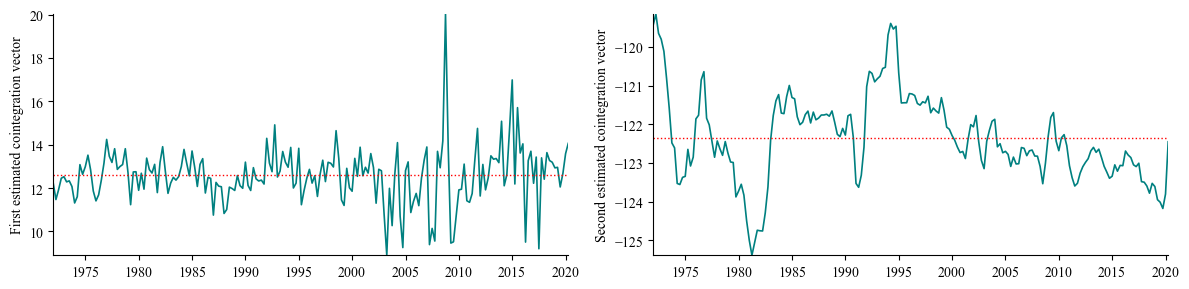

In [22]:
coint1 = np.dot(cointegration_vectors[0],np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab
coint2 = np.dot(cointegration_vectors[1],np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], coint1, f"First estimated cointegration vector", font_props, "Teal", mean_line=True)
SVAR_IT.setup_axis(axs[1], result['Dates'], coint2, f"Second estimated cointegration vector", font_props, "Teal", mean_line=True)
plt.tight_layout()
plt.show()

## $\text{Q9\quad Stationarity, Exclusion \& Weak Exogeneity}$

Test for stationarity, exclusion and weak exogeneity using either the Python function or the Matlab built-in function. Interpret your result.

In [23]:
print(f"For rank = {rank} and lags = {p-1}")
SVAR_TC.Stationary_Exclusion_Exogeneity(rank=float(rank), lags=p, LaTeX=False)

# Long run time

For rank = 2 and lags = 1


,,Stationarity,,Exclusion,,Weak Exogeneity
Foreign Interest,,22.64***,,0.267,,0.777
Gross Domestic Product,,23.57***,,13.114***,,4.742*
Inflation,,20.606***,,11.288***,,7.874**
Interest Rate,,24.52***,,0.196,,2.525
Exchange Rate,,0.708,,52.952***,,51.957***


## $\text{Q10\quad Further investigation}$

Bjørnland discusses in her paper possible cointegration vectors in the VAR system. How should hypotheses concerning PPP and UIP be formulated? Conduct a test of the implied cointegration vector(s). To gain further insights, provide a plot and discuss.

In [24]:
R_PPP = np.transpose(np.array([[-1, 0, 1, 0, -1]], dtype=np.float64))

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=float(rank), test=['bvec'], cons=R_PPP, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 13.7572 with a p-value of 0.0033. This
suggests that we reject the null that the cointegration
relationships do not exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

In [25]:
R_UIP = np.transpose(np.array([[-1, 0, 0, 1, 0]], dtype=np.float64))

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=float(rank), test=['bvec'], cons=R_UIP, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 19.4103 with a p-value of 0.0002. This
suggests that we reject the null that the cointegration
relationships do not exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

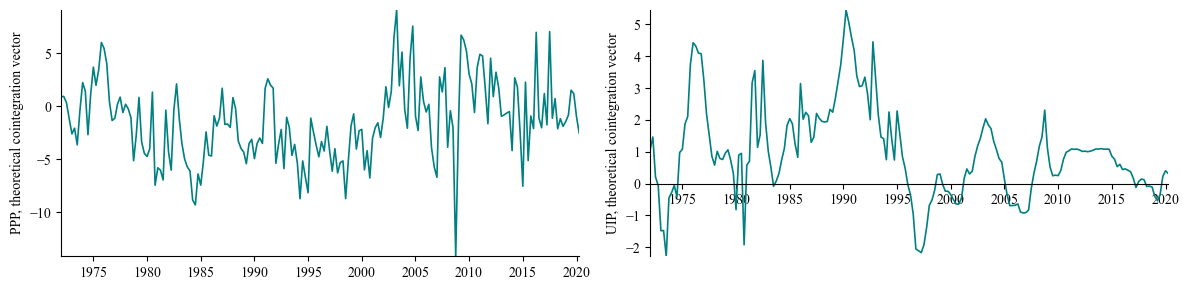

In [26]:
coint1 = np.dot(R_PPP.T.reshape(-1),np.array(y_clean_data).T)  
coint2 = np.dot(R_UIP.T.reshape(-1),np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], coint1, f"PPP, theoretical cointegration vector", font_props, "Teal", mean_line=False)
SVAR_IT.setup_axis(axs[1], result['Dates'], coint2, f"UIP, theoretical cointegration vector", font_props, "Teal", mean_line=False,at_zero=True)
plt.tight_layout()
plt.show()

# Homework Assignment 2
**Impulse responses and forecast error variance decomposition**

The assignment must be prepared either individually or in groups of three to four students but should be handed in individually in Absalon in pdf format. The title page must include a list of all members of the group. Everyone is responsible for writing their own code. All necessary programs must be submitted including a description of the analysis undertaken and a short discussion of the results. Note, only new functions coded in either Python or Matlab should be submitted. Any function distributed during lectures or exercises should not be submitted. Note that you are not allowed to use built-in functions available in Python/MATLAB unless otherwise stated.

This assignment focuses on tests impulse response functions and forecast error variance decomposition. We will continue to use the same data as in Homework Assignments 1. From the previous analysis you now have a well-specied VAR model corresponding to equation (1) in Bjørnland. Continue using this specication, i.e., the same ordering of the variables as in Bjørnland and the lag order you have found in the previous assignment. 

In [27]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC
SVAR_IRC = SVAR_IRC(Base_initialize,y_dataframe=y_clean_data, horizon = 25, lags=p, Constant=Constant, Trend=Trend, Exogenous=None)
Beta_theory = np.array([[0,0,-1,1]])
rank = 0

linear_combinations = None # {"Real interest": [f"{list_of_info[4]} - {list_of_info[3]}"],
#                        # Add more:
#                        }

print("\nLinear Combinations")
if not linear_combinations:
    linear_combinations = None
    print("  None")
else:
    for name, expressions in linear_combinations.items():
        for expr in expressions:
            print(f"  {name} = {expr}")

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944

Linear Combinations
  None


## $\text{Q11\quad Identify Structural VAR - Impulse Responses}$
Identify the structural VAR model using the restrictions dened in equation (3) and estimate the impulse responses of the interest rate and the real exchange rate to a monetary policy shock using the two dierent orderings of the data suggested by Bjørnland (either set $S_{45} = 0$ or $S_{54} = 0$ to just identify the structural VAR model). Compare your results to Figure 1 in the paper (gures B1 and B2). **Hint**: You can either identify the structural model using a Cholesky decomposition or you can use a solver to implement these restrictions.

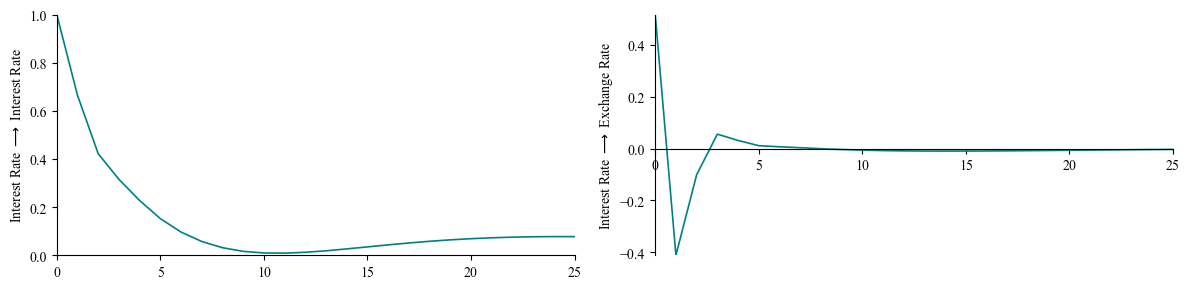

In [28]:
irf = SVAR_IRC.IRF(B0inv=None,VEC=False,VAR=True)
IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=list_of_info[4])#list_of_info[3]) # None)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], range(0,len(irf[:])), IRF_result[list_of_info[4]][list_of_info[4]],  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[4]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True)# y_axis=[0.01,-0.01])
SVAR_IT.setup_axis(axs[1], range(0,len(irf[:])), IRF_result[list_of_info[5]][list_of_info[4]],  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[5]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True)# y_axis=[0.01,-0.01])
plt.tight_layout()
plt.show()

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944
The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944


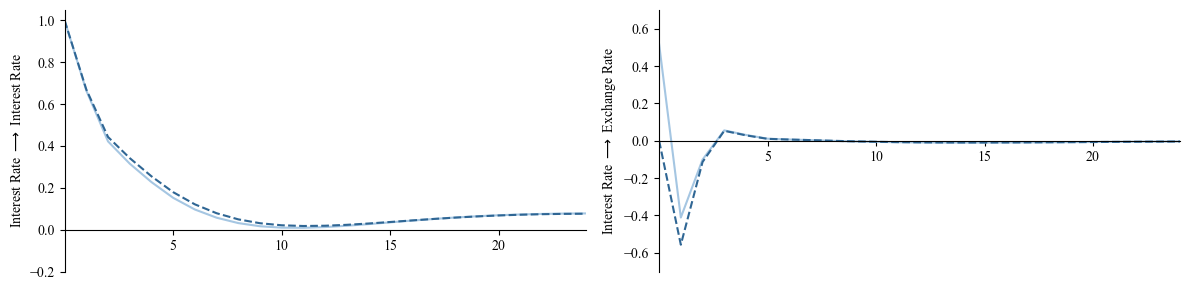

In [29]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as IRCSVAR_Test
# Define parameters
permuted_datasets = {}

permuted_datasets[0] = y_clean_data[['FedFunds', 'GDP', 'Infl', 'IntRate', 'ExchangeRate']].copy()
permuted_datasets[1] = y_clean_data[['FedFunds', 'GDP', 'Infl', 'ExchangeRate', 'IntRate']].copy()

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

for i in range(len(permuted_datasets)):
    IRCSVAR_instance = IRCSVAR_Test(Base_initialize, y_dataframe=permuted_datasets[i], horizon=24,
                                    lags=2, Constant=True, Trend=False, Exogenous=None)
    
    if i == 1:
        IRF_var = IRCSVAR_instance.IRF(B0inv=None,VEC=False,VAR=True, beta=np.ndarray, alpha=np.ndarray)
        list_of_info_2 = ['Dates: 1965-2015 (monthly)', 'Foreign Interest' , 'Gross Domestic Product' , 'Inflation' , 'Exchange Rate' , 'Interest Rate']
        IRF_result = IRCSVAR_instance.IRF_estimation(IRF_var=IRF_var,list_of_info=list_of_info_2, normalise="Interest Rate")
    else:
        IRF_var = IRCSVAR_instance.IRF(B0inv=None,VEC=False,VAR=True, beta=np.ndarray, alpha=np.ndarray)
        IRF_result = IRCSVAR_instance.IRF_estimation(IRF_var=IRF_var,list_of_info=list_of_info, normalise="Interest Rate")
    
    x_data_1 = IRF_result[list_of_info[4]].index
    y_data_1 = IRF_result[list_of_info[4]][list_of_info[4]]

    x_data_2 = IRF_result[list_of_info[4]].index
    y_data_2 = IRF_result[list_of_info[5]][list_of_info[4]]

    if i == 1:
        axs[0].plot(x_data_1, y_data_1, color=colors_navy[4], linestyle="--",label=r"$i=1")
        axs[1].plot(x_data_2, y_data_2, color=colors_navy[4], linestyle="--",label=r"i=1")
    else:
        axs[0].plot(x_data_1, y_data_1, color=colors_navy[0], linestyle="-",label=r"i=0")
        axs[1].plot(x_data_2, y_data_2, color=colors_navy[0], linestyle="-",label=r"i=0")

for ax in axs:
    ax.set_ylabel("IRF Response", fontname='Times New Roman')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

axs[0].set_ylabel("Interest Rate $\\longrightarrow$ Interest Rate", fontname='Times New Roman')
axs[1].set_ylabel("Interest Rate $\\longrightarrow$ Exchange Rate", fontname='Times New Roman')

for label in axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels() + axs[0].get_xticklabels():
    label.set_fontproperties(font_props)

handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

axs[0].set_ylim(-0.2,1.05)
axs[1].set_ylim(-0.7,0.7)

axs[0].set_xlim(0.001,max(x_data_1))
axs[1].set_xlim(0.001,max(x_data_1))

plt.tight_layout()
plt.show()

## $\text{Q12\quad Forecast Error Variance Decomposition}$
Estimate the forecast error variance decomposition focusing on the contribution of monetary policy shocks and real exchange rate shocks. Are results dependent on how we order the interest rate and the real exchange rate?

In [30]:
FEVD_long_run = SVAR_IRC.FEVD(B0inv=None,VAR=True)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=FEVD_long_run, list_of_info=list_of_info, normalise=None)

In [31]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as IRCSVAR_FEVD
IRCSVAR_FEVD = IRCSVAR_FEVD(Base_initialize,y_dataframe=y_clean_data , horizon = 1000, lags=2, Constant=True, Trend=False, Exogenous=None)

FEVD_long_run = IRCSVAR_FEVD.FEVD(B0inv=None,VAR=True)
FEVD_result = IRCSVAR_FEVD.FEVD_estimation(FEVD_var=FEVD_long_run, list_of_info=list_of_info, normalise=None)

selected_rows = [0,5,10,20,50,100,200,500,1000]

for shock in range(1, 6):
    data = np.vstack([FEVD_result[list_of_info[l]][list_of_info[shock]] for l in range(1, len(list_of_info))])
    transposed_data = data.T
    filtered_data = transposed_data[selected_rows, :]
    print(list_of_info[shock])
    if shock == 5:
        latex_table = "\\begin{tabular}{" + "c" * (len(list_of_info_latex)+1) + "}"+ "\\\\\\hline~\\vspace{-0.3cm}\\\\\n"
    else:
        latex_table = "\\begin{tabular}{" + "c" * (len(list_of_info_latex)+1) + "}\n"
    
    latex_table += "$h$ & " + " & ".join(list_of_info_latex) + "\\\\\n"
    
    for i, row in enumerate(filtered_data):
        latex_table += f"{selected_rows[i]} & " + " & ".join(f"{val*100:.2f}\%" for val in row) + " \\\\\n"
    
    latex_table += "\\end{tabular}\n"
    latex_name = f"{LaTeX_path}/Table/12_FEVD_{list_of_info[shock].replace(' ','_')}.tex"
    print(latex_table)


The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944
Foreign Interest
\begin{tabular}{cccccc}
$h$ & $i^\ast_t$ & $y_t$ & $\pi_t$ & $i_t$ & $\Delta e_t$\\
0 & 100.00\% & 0.00\% & 0.00\% & 0.00\% & 0.00\% \\
5 & 70.37\% & 24.58\% & 0.55\% & 4.11\% & 0.39\% \\
10 & 66.46\% & 24.25\% & 2.92\% & 5.98\% & 0.39\% \\
20 & 63.94\% & 23.47\% & 5.82\% & 6.37\% & 0.40\% \\
50 & 61.17\% & 26.59\% & 5.92\% & 5.93\% & 0.41\% \\
100 & 58.72\% & 29.23\% & 6.19\% & 5.47\% & 0.39\% \\
200 & 56.83\% & 31.28\% & 6.40\% & 5.11\% & 0.38\% \\
500 & 56.04\% & 32.13\% & 6.48\% & 4.97\% & 0.38\% \\
1000 & 56.02\% & 32.16\% & 6.49\% & 4.96\% & 0.38\% \\
\end{tabular}

Gross Domestic Product
\begin{tabular}{cccccc}
$h$ & $i^\ast_t$ & $y_t$ & $\pi_t$ & $i_t$ & $\Delta e_t$\\
0 & 0.69\% & 99.31\% & 0.00\% & 0.00\% & 0.00\% \\
5 & 0.32\% & 96.04\% & 1.25\% & 1.50\% & 0.89\% \\
10 & 2.75\% & 88.79\% & 5.56\% & 2.14\% & 0.76\% \\
20 & 10.51\% & 76.87\% & 10.13\% & 1.96\% & 0.53\% \\
50 & 20.05\

In [32]:
permuted_datasets = {}
permuted_datasets[0] = y_clean_data[['FedFunds', 'GDP', 'Infl', 'IntRate', 'ExchangeRate']].copy()
permuted_datasets[1] = y_clean_data[['FedFunds', 'GDP', 'Infl', 'ExchangeRate', 'IntRate']].copy()

selected_rows = [1,5,10,20,50,100,200,500,1000,10000]


for i in range(len(permuted_datasets)):
    from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as IRCSVAR_FEVD_test
    IRCSVAR_FEVD_test = IRCSVAR_FEVD_test(Base_initialize,y_dataframe=permuted_datasets[i], 
                                horizon = 10000, lags=2, Constant=True, Trend=False, Exogenous=None)

    if i == 1:
        FEVD_long_run = IRCSVAR_FEVD_test.FEVD(B0inv=None, VAR=True)
        list_of_info_2 = ['Dates: 1965-2015 (monthly)', 'Foreign Interest' , 'Gross Domestic Product' , 'Inflation' , 'Exchange Rate' , 'Interest Rate']
        FEVD_result = IRCSVAR_FEVD_test.FEVD_estimation(FEVD_var=FEVD_long_run, list_of_info=list_of_info_2, normalise=None)
    else:
        FEVD_long_run = IRCSVAR_FEVD_test.FEVD(B0inv=None, VAR=True)
        FEVD_result = IRCSVAR_FEVD_test.FEVD_estimation(FEVD_var=FEVD_long_run, list_of_info=list_of_info, normalise=None)

    for shock in [4,5]:
        #data = np.vstack([FEVD_result[list_of_info[shock]][list_of_info[l]] for l in range(1, len(list_of_info))])
        if i == 1:
            data = np.vstack([FEVD_result[list_of_info_2[l]][list_of_info_2[shock]] for l in range(1, len(list_of_info_2))])
        else:
            data = np.vstack([FEVD_result[list_of_info[l]][list_of_info[shock]] for l in range(1, len(list_of_info))])

        transposed_data = data.T
        filtered_data = transposed_data[[x - 1 for x in selected_rows], :]
        
   
        latex_table = "\\begin{tabular}{" + "c" * (len(list_of_info_latex)+1) + "}\n"
        if i == 1:
            list_of_info_latex_2 = ['$i^\\ast_t$', '$y_t$', '$\\pi_t$', '$\\Delta e_t$','$i_t$']
            latex_table += "$h$ & " + " & ".join(list_of_info_latex_2) + "\\\\\n"
        else:
            latex_table += "$h$ & " + " & ".join(list_of_info_latex) + "\\\\\n"

        for j, row in enumerate(filtered_data):
            latex_table += f"{selected_rows[j]} & " + " & ".join(f"{val*100:.2f}\%" for val in row) + " \\\\\n"
        
        latex_table += "\\end{tabular}\n"
        if i == 1:
            latex_name = f"{LaTeX_path}/Table/12_{i}_FEVD_{list_of_info_2[shock].replace(' ','_')}.tex"
        else:
            latex_name = f"{LaTeX_path}/Table/12_{i}_FEVD_{list_of_info[shock].replace(' ','_')}.tex"

        latex_table = latex_table.replace("10000","$\infty$")
        latex_table = latex_table.replace("\n0 &","1 &")


        if i ==1:
            print(f"12_{i}_FEVD_{list_of_info_2[shock].replace(' ','_')}.tex")
        else:
            print(f"12_{i}_FEVD_{list_of_info[shock].replace(' ','_')}.tex")

        print(latex_table)

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944
12_0_FEVD_Interest_Rate.tex
\begin{tabular}{cccccc}
$h$ & $i^\ast_t$ & $y_t$ & $\pi_t$ & $i_t$ & $\Delta e_t$\\
1 & 44.79\% & 0.02\% & 0.32\% & 54.86\% & 0.00\% \\
5 & 48.37\% & 40.92\% & 1.04\% & 8.91\% & 0.76\% \\
10 & 44.59\% & 47.83\% & 1.00\% & 5.56\% & 1.02\% \\
20 & 44.94\% & 46.40\% & 2.62\% & 5.06\% & 0.98\% \\
50 & 44.73\% & 46.41\% & 2.98\% & 4.96\% & 0.92\% \\
100 & 43.60\% & 47.44\% & 3.56\% & 4.55\% & 0.85\% \\
200 & 42.69\% & 48.28\% & 4.00\% & 4.23\% & 0.80\% \\
500 & 42.32\% & 48.62\% & 4.18\% & 4.10\% & 0.78\% \\
1000 & 42.30\% & 48.64\% & 4.18\% & 4.09\% & 0.78\% \\
$\infty$ & 42.30\% & 48.64\% & 4.18\% & 4.09\% & 0.78\% \\
\end{tabular}

12_0_FEVD_Exchange_Rate.tex
\begin{tabular}{cccccc}
$h$ & $i^\ast_t$ & $y_t$ & $\pi_t$ & $i_t$ & $\Delta e_t$\\
1 & 0.02\% & 1.22\% & 0.64\% & 1.26\% & 96.86\% \\
5 & 0.59\% & 1.46\% & 0.78\% & 1.93\% & 95.24\% \\
10 & 0.61\% & 1.47\% & 0.84\% & 1.93\% & 9

## $\text{Q13\quad Invariant to a different Specication of }e_t$
In footnote 7 on page 67, Bjørnland argues that the main results remain invariant to the specication of the real exchange rate, i.e., if we use the level of the real exchange rate instead of the rst dierence. Is this statement correct?

In [33]:
datesQ = dataQ.iloc[:, 0]
GDP = np.log(dataQ.iloc[:, 1])
IntRate = dataQ.iloc[:, 3]

resultTable1 = pd.DataFrame({'Dates': datesQ, 'GDP': GDP, 'IntRate': IntRate})

# Load and process monthly data
datesM = dataM.iloc[:, 0]
ExchangeRate = dataM.iloc[:, 1]
FedFunds = dataM.iloc[:, 2]
CPIMonthly = dataM.iloc[:, 4]
IntRateMonthly = dataM.iloc[:, 5]

# Aggregate monthly data to quarterly means
TimeTable1 = pd.DataFrame({'Dates': datesM, 'ExchangeRate': ExchangeRate, 'FedFunds': FedFunds, 'IntRateMonthly': IntRateMonthly})
TimeTable1.set_index('Dates', inplace=True)
TimeTable1 = TimeTable1.resample('QS').mean()

ExchangeRateQ = TimeTable1.iloc[:, 0]
FedFundsQ = TimeTable1.iloc[:, 1]
IntRateQ = TimeTable1.iloc[:, 2]

# Calculate exchange rate changes
ExchangeRate = np.log(ExchangeRateQ)#100 * (np.log(ExchangeRateQ) - np.log(ExchangeRateQ.shift(1)))

TimeTable1 = pd.concat([ExchangeRate, FedFundsQ, IntRateQ], axis=1)

Infl = 100 * (np.log(CPIMonthly) - np.log(CPIMonthly.shift(12)))

TimeTable2 = pd.DataFrame({'Dates': datesM, 'Infl': Infl})
TimeTable2.set_index('Dates', inplace=True)
TimeTable2 = TimeTable2.resample('QS').mean()

resultTable2 = pd.merge(TimeTable1, TimeTable2, on='Dates', how='left')

resultTable2

result = pd.merge(resultTable1, resultTable2, on='Dates', how='left')
result = result[['Dates', 'FedFunds', 'GDP', 'Infl', 'IntRate', 'ExchangeRate']]
result = result.dropna()
result.reset_index(inplace=True,drop=True)
date_column_name = [col for col in result.columns if col == 'Dates']
date_column_name = date_column_name[0]

y_clean_level_data = SVAR_IT.clean_data(result=result,display_data=False)

In [34]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as IRCSVAR_Level
IRCSVAR_Level = IRCSVAR_Level(Base_initialize,y_dataframe=y_clean_level_data ,horizon = 24, lags=2, Constant=True, Trend=False, Exogenous=None)

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9935


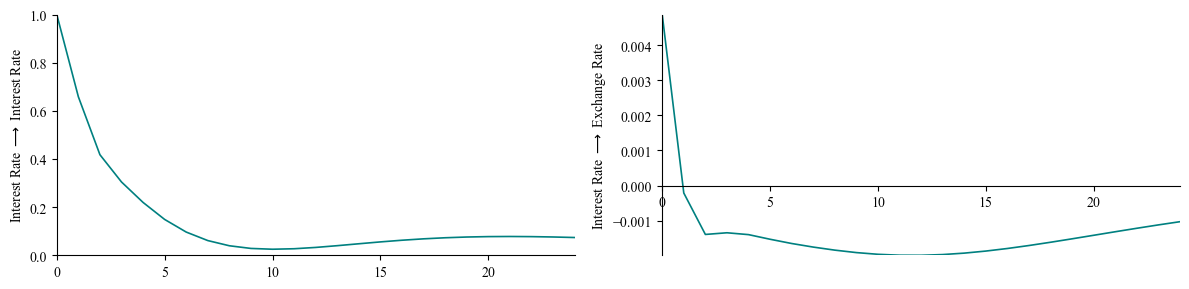

In [35]:
irf = IRCSVAR_Level.IRF(B0inv=None,VEC=False,VAR=True)
IRF_result_level = IRCSVAR_Level.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=list_of_info[4])#list_of_info[3]) # None)
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], range(0,len(irf[:])), IRF_result_level[list_of_info[4]][list_of_info[4]],  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[4]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True)# y_axis=[0.01,-0.01])
SVAR_IT.setup_axis(axs[1], range(0,len(irf[:])), IRF_result_level[list_of_info[5]][list_of_info[4]],  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[5]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True)# y_axis=[0.01,-0.01])
plt.tight_layout()
plt.show()

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9935
The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9935


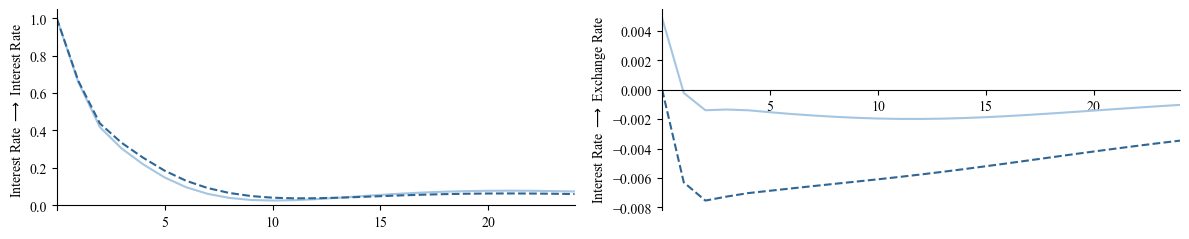

In [36]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as IRCSVAR_Test
permuted_datasets = {}
permuted_datasets[0] = y_clean_level_data[['FedFunds', 'GDP', 'Infl', 'IntRate', 'ExchangeRate']].copy()
permuted_datasets[1] = y_clean_level_data[['FedFunds', 'GDP', 'Infl', 'ExchangeRate', 'IntRate']].copy()

fig, axs = plt.subplots(1, 2, figsize=(12,2.5))

for i in range(len(permuted_datasets)):
    IRCSVAR_instance = IRCSVAR_Test(Base_initialize, y_dataframe=permuted_datasets[i], horizon=24,
                                    lags=2, Constant=True, Trend=False, Exogenous=None)
    
    if i == 1:
        IRF_var = IRCSVAR_instance.IRF(B0inv=None,VEC=False,VAR=True, beta=np.ndarray, alpha=np.ndarray)
        list_of_info_2 = ['Dates: 1965-2015 (monthly)', 'Foreign Interest' , 'Gross Domestic Product' , 'Inflation' , 'Exchange Rate' , 'Interest Rate']
        IRF_result = IRCSVAR_instance.IRF_estimation(IRF_var=IRF_var,list_of_info=list_of_info_2, normalise="Interest Rate")
    else:
        IRF_var = IRCSVAR_instance.IRF(B0inv=None,VEC=False,VAR=True, beta=np.ndarray, alpha=np.ndarray)
        IRF_result = IRCSVAR_instance.IRF_estimation(IRF_var=IRF_var,list_of_info=list_of_info, normalise="Interest Rate")
    
    
    x_data_1 = IRF_result[list_of_info[4]].index
    y_data_1 = IRF_result[list_of_info[4]][list_of_info[4]]

    x_data_2 = IRF_result[list_of_info[4]].index
    y_data_2 = IRF_result[list_of_info[5]][list_of_info[4]]

    if i == 1:
        axs[0].plot(x_data_1, y_data_1, color=colors_navy[4], linestyle="--",label=r"$i^\ast_t\quad y_t,\quad \pi_t,\quad  e_t,\quad i_t$")
        axs[1].plot(x_data_2, y_data_2, color=colors_navy[4], linestyle="--")
    else:
        axs[0].plot(x_data_1, y_data_1, color=colors_navy[0], linestyle="-",label=r"$i^\ast_t\quad y_t,\quad \pi_t,\quad i_t,\quad e_t$")
        axs[1].plot(x_data_2, y_data_2, color=colors_navy[0], linestyle="-")

for ax in axs:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

axs[0].set_ylabel("Interest Rate $\\longrightarrow$ Interest Rate", fontname='Times New Roman')
axs[1].set_ylabel("Interest Rate $\\longrightarrow$ Exchange Rate", fontname='Times New Roman')

for label in axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels() + axs[0].get_xticklabels():
    label.set_fontproperties(font_props)

handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)


axs[0].set_xlim(0.001,max(x_data_1))
axs[1].set_xlim(0.001,max(x_data_1))
plt.tight_layout()
plt.show()

## $\text{Q14\quad Alternative Identication – long and short-run restrictions}$
Bjørnland suggests an alternative identication in section 2 (equations ($4$) and ($5$)). Use a solver to implement this identication. Hint: This is a combination of long-run and short-run restrictions, i.e., restrictions on both $B^{-1}_0$ and $\Theta(1)$.

<!-- Furthermore, she defines:

\begin{equation*}
    C(1)=B(1)S
\end{equation*}

which is equivalent to our:

\begin{equation*}
\Upsilon=\Xi B_{0}^{-1}
\end{equation*}
***
$$
\begin{align*}
\Upsilon&=\Xi B_{0}^{-1}\\
C(1)&=B(1)S\\
&=
\begin{pmatrix}
B_{11} & B_{11} & B_{12} & B_{14} & B_{15} \\
B_{21} & B_{22} & B_{22} & B_{24} & B_{25} \\
B_{31} & B_{32} & B_{33} & B_{34} & B_{35} \\
B_{41} & B_{42} & B_{43} & B_{44} & B_{45} \\
B_{51} & B_{52} & B_{53} & B_{54} & B_{55} \\
\end{pmatrix}
\begin{pmatrix}
S_{11} & 0      & 0      & 0      & 0      \\
S_{21} & S_{22} & 0      & 0      & 0      \\
S_{31} & S_{32} & S_{33} & 0      & 0      \\
S_{41} & S_{42} & S_{43} & S_{43} & 0      \\
S_{51} & S_{52} & S_{54} & S_{54} & S_{55} \\
\end{pmatrix}
\\
&=\begin{pmatrix}
C_{11}(1) & C_{12}(1) & C_{13}(1) & C_{14}(1) & C_{15}(1) \\
C_{21}(1) & C_{22}(1) & C_{23}(1) & C_{24}(1) & C_{25}(1) \\
C_{31}(1) & C_{32}(1) & C_{33}(1) & C_{34}(1) & C_{35}(1) \\
C_{41}(1) & C_{42}(1) & C_{43}(1) & C_{44}(1) & C_{45}(1) \\
C_{51}(1) & C_{52}(1) & C_{53}(1) & C_{54}(1) & C_{55}(1) \\
\end{pmatrix}
\end{align*}
$$

$B_{51}(1)S_{14}+B_{52}(1)S_{24}+B_{53}(1)S_{34}+B_{54}(1)S_{44}+B_{55}(1)S_{54}=0:\quad  \Rightarrow \quad C_{54}(1)=0$

$$
C(1)=\begin{pmatrix}
C_{11}(1) & C_{12}(1) & C_{13}(1) & C_{14}(1) & C_{15}(1) \\
C_{21}(1) & C_{22}(1) & C_{23}(1) & C_{24}(1) & C_{25}(1) \\
C_{31}(1) & C_{32}(1) & C_{33}(1) & C_{34}(1) & C_{35}(1) \\
C_{41}(1) & C_{42}(1) & C_{43}(1) & C_{44}(1) & C_{45}(1) \\
C_{51}(1) & C_{52}(1) & C_{53}(1) & 0 & C_{55}(1) \\
\end{pmatrix}
$$ -->

In [37]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC
SVAR_IRC = SVAR_IRC(Base_initialize,y_dataframe=y_clean_data,horizon=24, lags=2, Constant=True, Trend=False, Exogenous=None)
horizon = 24

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944


In [38]:
SVAR_TC.Identication_Scheme(rank)

Since the rank r = 0, there are 0 transitory/temporary shocks.
Thus, there are K-r = 5 permanent shocks.

    To identify the permanent shocks, we need (K-r)(K-r-1)/2 = 10 restrictions. (Upsilon)
    To identify the transitory shocks, we need r(r-1)/2 = 0 restrictions. (B^{-1}_0)


In [39]:
B_R = """[* 0 0 0 0
          * * 0 0 0
          * * * 0 0
          * * * * *
          * * * * *]"""

U_R = """[* * * * * 
          * * * * * 
          * * * * * 
          * * * * *
          * * * 0 *]"""

In [40]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=0)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=None),
                        np.random.randn(K * K))#, xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))
Upsilon_solve = Xi @ B0inv
B0inv_solve = B0inv

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
0.82517 & -0.00000 & 0.00000 & 0.00000 & 0.00000 \\
0.00087 & 0.01039 & -0.00000 & -0.00000 & -0.00000 \\
0.09436 & 0.08247 & 0.70140 & 0.00000 & -0.00000 \\
0.49615 & 0.01056 & 0.04208 & 0.54902 & 0.00936 \\
-0.03932 & -0.27913 & -0.20269 & 0.24100 & 2.49483 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
24.34762 & -19.29838 & 6.30807 & -0.54489 & 1.17883 \\
-1.55485 & 2.27993 & -0.89014 & -0.22580 & -0.15255 \\
13.90927 & -17.82595 & 11.45969 & -0.88770 & 1.07280 \\
29.91822 & -19.99425 & 9.53927 & 5.00581 & 0.76278 \\
0.49602 & -1.16290 & 0.22518 & 0.00000 & 3.32614 \\
\end{pmatrix}


## $\text{Q15\quad Identify Structural VAR - Impulse Responses}$
Identify the structural VAR and estimate the impulse response and forecast error variance decomposition. Compare the impulse responses of the variables to a monetary policy shock to the ones provided in Figure 3 and compare the forecast error variance to the results provided in Table 1. Are your results consistent with the estimates in Bjørnland?

In [41]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=False,VAR=True)
fevd = SVAR_IRC.FEVD_IRF(irf=irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=list_of_info[4])#list_of_info[3]) # None)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=None)

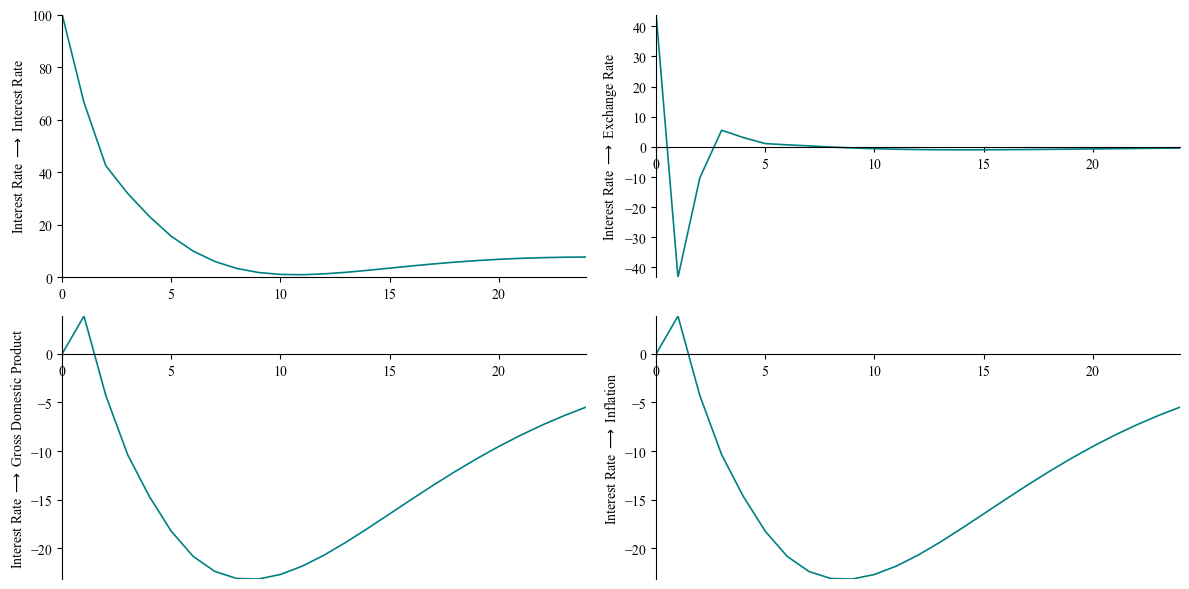

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
SVAR_IT.setup_axis(axs[0,0], range(0,horizon+1), IRF_result[list_of_info[4]][list_of_info[4]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[4]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[1,-0.3])
SVAR_IT.setup_axis(axs[0,1], range(0,horizon+1), IRF_result[list_of_info[5]][list_of_info[4]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[5]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[0.5,-0.5])
SVAR_IT.setup_axis(axs[1,0], range(0,horizon+1), IRF_result[list_of_info[3]][list_of_info[4]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[2]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[0.005,-0.007])
SVAR_IT.setup_axis(axs[1,1], range(0,horizon+1), IRF_result[list_of_info[3]][list_of_info[4]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[3]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[0.35,-0.35])
plt.tight_layout()
plt.show()

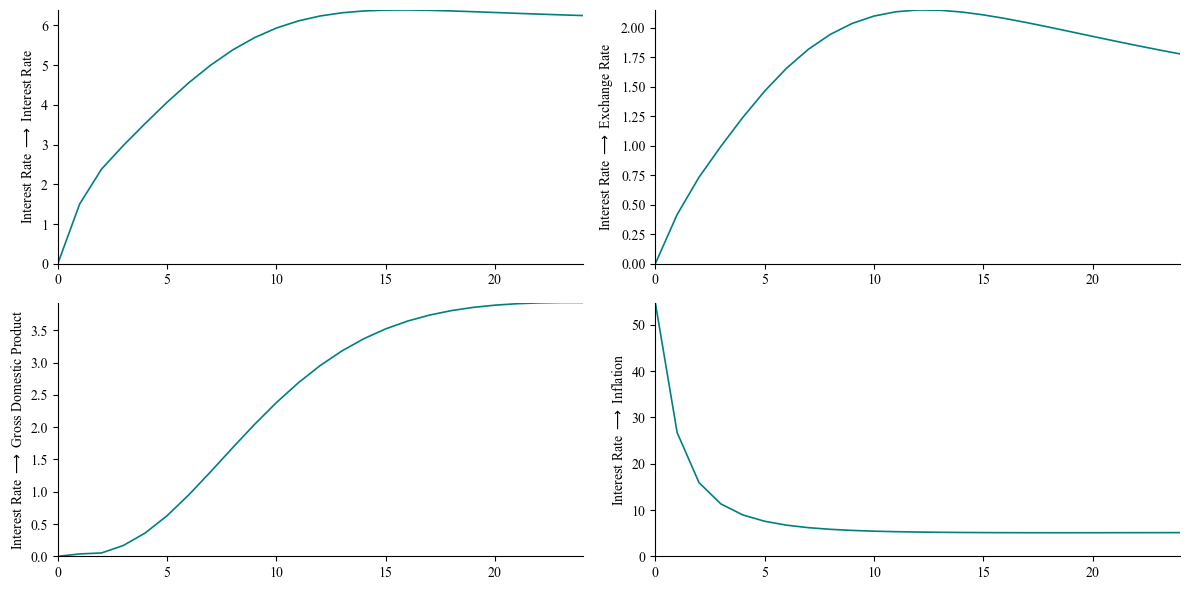

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
SVAR_IT.setup_axis(axs[0,0], range(0,horizon+1), FEVD_result[list_of_info[4]][list_of_info[1]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[4]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[1,-0.3])
SVAR_IT.setup_axis(axs[0,1], range(0,horizon+1), FEVD_result[list_of_info[4]][list_of_info[2]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[5]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[0.5,-0.5])
SVAR_IT.setup_axis(axs[1,0], range(0,horizon+1), FEVD_result[list_of_info[4]][list_of_info[3]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[2]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[0.005,-0.007])
SVAR_IT.setup_axis(axs[1,1], range(0,horizon+1), FEVD_result[list_of_info[4]][list_of_info[4]]*100,  f"{list_of_info[4]} $\\longrightarrow$ {list_of_info[3]}", font_props, "teal", mean_line=False,special_data_format=[False,10],at_zero=True, y_axis=[0.35,-0.35])
plt.tight_layout()
plt.show()

## $\text{Q16\quad Confidence Bands for Impulse Responses - Bootstrap}$
Use the standard residual-based recursive design bootstrap method and the delta method to construct condence bands for impulse responses in the three structural VAR models in Bjørnlands paper with 500 replications. In each replication, check that the identication is valid and that the VAR model is stable. If the identication is not
valid or the model is not stable then discard that replication. Count the number of invalid replications and comment on your results. Present the impulse responses in graphs and comment on your results.

In [44]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC
SVAR_IRC = SVAR_IRC(Base_initialize,y_dataframe=y_clean_data ,horizon = 24, lags=2, Constant=True, Trend=False, Exogenous=None)

The estimated VAR model is stable. The largest absolute eigenvalue is: 0.9944


In [45]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=False,VAR=True)
fevd = SVAR_IRC.FEVD_IRF(irf=irf)

In [46]:
IRFmat, VCmat = SVAR_IRC.VAR_Bootstrap(n_trials=500, Bootstrap = True, Bootstrap_type ="W ild", 
                        Orthogonal = False, iterations=300, B0inv_R=B_R, Upsilon_R=U_R, initial_guess=B0inv)

Trial: 500 of 525  |  Failures due to solver: 6 | Failures due to unstable eigenvalue: 19
Bootstrap based on: 500 trials
Bootstrap type in use: non parametric
Unstable replications: 19


Impulse Response Function
Bootstrap (Non Parametric) Confidence Intervals (Delta)


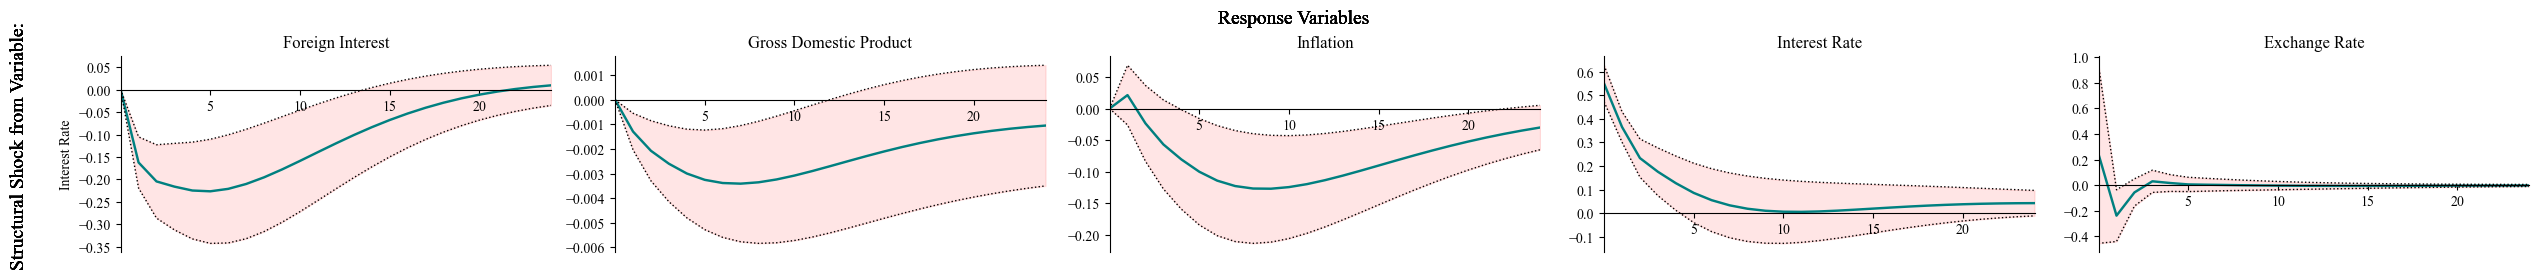

In [47]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = linear_combinations, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta",  # or "Efron" can be extended.
    responses = None,      # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [4],         # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68],            # mulitple e.g. z_values=[95,68]
    Baseline = irf,             
    Info="Non Parametric",      # VEC_Bootstrap() setting
    )

## $\text{Q18\quad Confidence Bands for FEVD - Efron}$
Use Efron's percentile method to compute condence bands for forecast error variance decomposition computed using the three structural VAR models in Bjørnland. Show the results either in a graph or in a table with point estimates and standard errors.

Forecast Error Variance Decomposition
Bootstrap (Non Parametric) confidence intervals (Efron)


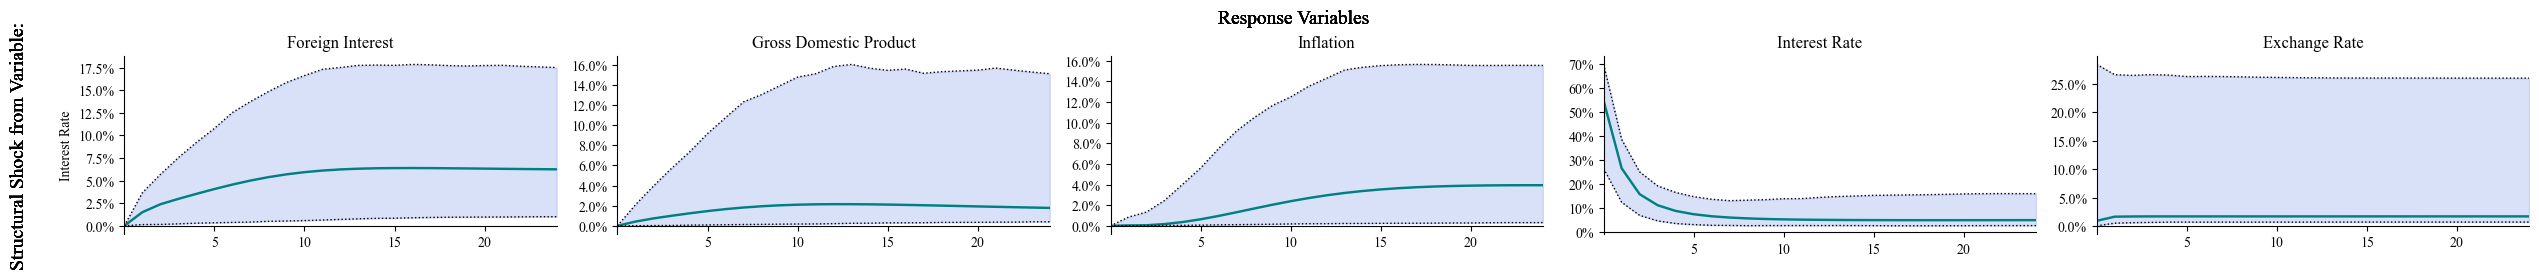

In [48]:
SVAR_IRC.FEVD_Combined_Plots(
    Bootstrap_Matrix = VCmat,
    confidence_type ="Efron", # can be extended.
    responses = None, # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [4],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [5], # mulitple e.g. z_values=[95,68]
    Baseline = fevd*100, 
    Info="Non Parametric")

## $\text{Q19\quad Confidence Bands for FEVD - Delta}$
As an alternative to Efron's approach, use the delta method to compute the condence bands for forecast error variance decomposition. Compare and comment on the dierences.

Forecast Error Variance Decomposition
Bootstrap (Non Parametric) confidence intervals (Delta)


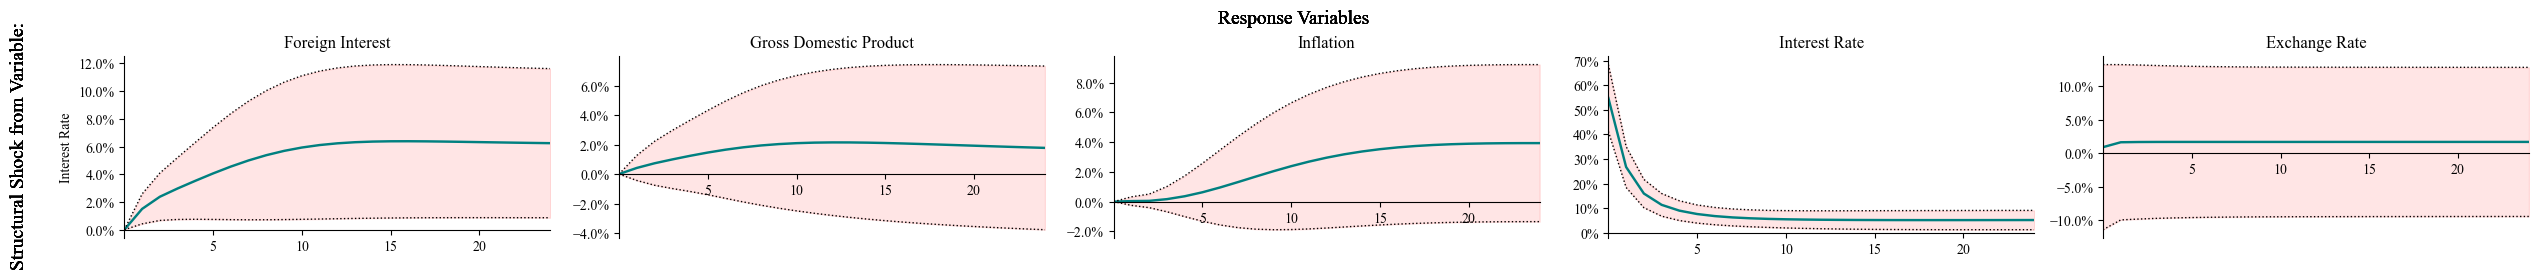

In [49]:
SVAR_IRC.FEVD_Combined_Plots(Baseline=fevd*100, Bootstrap_Matrix=VCmat, 
                                  z_values=[68], confidence_type ="Delta", Info="Non Parametric",
                                 shocks = [4], responses = None)